In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings

from nltk.tokenize import sent_tokenize
import gensim.parsing.preprocessing as gen_preproc

import spacy
nlp = spacy.load('en_core_web_sm')

warnings.filterwarnings('ignore')

# Data Import 
The same stuff I've done in all the file / models.

In [2]:
df = pd.read_csv( 'parsed_train.txt', sep='\t', header=None,
                   names=['label', 'text'] )
df['label'] = df['label'].apply(lambda x: int( x.replace("__label__", "") ) )

basicPreproc = [lambda x: x.lower(), gen_preproc.strip_tags, \
    gen_preproc.strip_punctuation, gen_preproc.strip_non_alphanum, \
    gen_preproc.strip_multiple_whitespaces] #, gen_preproc.strip_short, gen_preproc.remove_stopwords

df['basicProc'] = df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
df['stemmed'] = df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
df['lemmatized'] = df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )
df.head()

,label,text,basicProc,stemmed,lemmatized
0,4,The Rock is destined to be the 21st Century 's...,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...
1,5,The gorgeously elaborate continuation of `` Th...,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...
2,4,Singer/composer Bryan Adams contributes a slew...,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...
3,3,You 'd think by now America would have had eno...,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...
4,4,Yet the act is still charming here .,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here


### Test Loading

In [3]:
test_df = pd.read_csv( 'parsed_test.txt', sep='\t', header=None,
                   names=['label', 'text'] )
test_df['label'] = test_df['label'].apply(lambda x: int( x.replace("__label__", "") ) )
test_df['basicProc'] = test_df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
test_df['stemmed'] = test_df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
test_df['lemmatized'] = test_df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )
test_df.head()

,label,text,basicProc,stemmed,lemmatized
0,3,Effective but too-tepid biopic,effective but too tepid biopic,effect but too tepid biopic,effective but too tepid biopic
1,4,If you sometimes like to go to the movies to h...,if you sometimes like to go to the movies to h...,if you sometim like to go to the movi to have ...,if -PRON- sometimes like to go to the movie to...
2,5,"Emerges as something rare , an issue movie tha...",emerges as something rare an issue movie that ...,emerg as someth rare an issu movi that s so ho...,emerge as something rare an issue movie that s...
3,3,The film provides some great insight into the ...,the film provides some great insight into the ...,the film provid some great insight into the ne...,the film provide some great insight into the n...
4,5,Offers that rare combination of entertainment ...,offers that rare combination of entertainment ...,offer that rare combin of entertain and educ,offer that rare combination of entertainment a...


In [4]:
# Load Bert
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = \
    ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased'

In [5]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

100%|██████████| 267967963/267967963 [00:17<00:00, 15583598.05B/s]


### Prep BERT Input Format

In [8]:
tokenized = df['lemmatized'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized[0]

[101,
 1996,
 2600,
 2022,
 4078,
 10196,
 2000,
 2022,
 1996,
 7398,
 2301,
 1055,
 2047,
 16608,
 1998,
 2008,
 1011,
 4013,
 2078,
 1011,
 1055,
 2175,
 2000,
 2191,
 1037,
 17624,
 2130,
 2307,
 2084,
 7779,
 29058,
 8625,
 13327,
 3744,
 18856,
 19513,
 3158,
 5477,
 4168,
 2030,
 7112,
 16562,
 2140,
 102]

In [37]:
#Padding where everything is padded to the max length. Could use other functions for padding as well.
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(8544, 71)

In [10]:
padded[0]

array([  101,  1996,  2600,  2022,  4078, 10196,  2000,  2022,  1996,
        7398,  2301,  1055,  2047, 16608,  1998,  2008,  1011,  4013,
        2078,  1011,  1055,  2175,  2000,  2191,  1037, 17624,  2130,
        2307,  2084,  7779, 29058,  8625, 13327,  3744, 18856, 19513,
        3158,  5477,  4168,  2030,  7112, 16562,  2140,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0])

Masked features tell BERT to Ignore the padding bits. This is important b.c. it means we're not diluting our information when padding, and that having long padding doesn't matter

In [38]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(8544, 71)

In [18]:
attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [23]:
input_ids = torch.tensor(padded)
input_ids = input_ids.to(input_ids.device).long() 
attention_mask = torch.tensor(attention_mask)
attention_mask = attention_mask.to(attention_mask.device).long()

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 7454195712 bytes. Buy new RAM!


# Not Enough RAM hahaha
Ok... lets cut it down into chunks. I have ~32 GB ram. That used only 7.5 gb if my math is correct? Maybe Jupyter has a max allocated to it? Note that numpy array split will keep the indexing the same, so don't needa zip & unzip stuff.

In [24]:
7454195712 / 1e9

7.454195712

In [39]:
paddedChunks = np.array_split( padded, 5 )
attentionChunks = np.array_split( attention_mask, 5 )

In [40]:
paddedChunks[0].shape

(1709, 71)

In [28]:
def get_hidden_states(paddedChunk, attentionChunk):
    input_ids = torch.tensor(paddedChunk)
    input_ids = input_ids.to(input_ids.device).long() 
    attention_mask = torch.tensor(attentionChunk)
    attention_mask = attention_mask.to(attention_mask.device).long()

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
        
    return last_hidden_states


In [41]:
last_hidden_states_0 = get_hidden_states(paddedChunks[0], attentionChunks[0])
features_0 = last_hidden_states_0[0][:,0,:].numpy()

In [42]:
last_hidden_states_1 = get_hidden_states(paddedChunks[1], attentionChunks[1])
features_1 = last_hidden_states_1[0][:,0,:].numpy()

In [43]:
last_hidden_states_2 = get_hidden_states(paddedChunks[2], attentionChunks[2])
features_2 = last_hidden_states_2[0][:,0,:].numpy()

In [44]:
last_hidden_states_3 = get_hidden_states(paddedChunks[3], attentionChunks[3])
features_3 = last_hidden_states_3[0][:,0,:].numpy()

In [45]:
last_hidden_states_4 = get_hidden_states(paddedChunks[4], attentionChunks[4])
features_4 = last_hidden_states_4[0][:,0,:].numpy()

In [47]:
train_Y = np.array_split( np.array( list( df['label'] ) ), 5 )
train_Y_0 = train_Y[0]
train_Y_1 = train_Y[1]
train_Y_2 = train_Y[2]
train_Y_3 = train_Y[3]
train_Y_4 = train_Y[4]

In [48]:
lr_clf = LogisticRegression()
lr_clf.fit(features_0, train_Y_0)
lr_clf.fit(features_1, train_Y_1)
lr_clf.fit(features_2, train_Y_2)
lr_clf.fit(features_3, train_Y_3)
lr_clf.fit(features_4, train_Y_4)

LogisticRegression()

## Running with Test

In [83]:
test_tokenized = test_df['lemmatized'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
test_padded = np.array( [i + [0]*(max_len-len(i)) for i in test_tokenized.values] )

#AHHHH, The longest in Test Padded is Longer than in the Training set! 
#This caused test_padded to be an array of lists instead of 2d array
lens = [len(i) for i in test_padded]
print(all([i == 71 for i in lens]))
for i, length in enumerate(lens):
    if length != 71:
        print(i, length)
        print()
        print(test_padded[i])

#Cut off to len 71 only.
test_padded = np.array( [np.array( i[:max_len] ) for i in test_padded] )

test_attention_mask = np.where(test_padded != 0, 1, 0)
print( np.array(test_padded).shape )
print( np.array(test_attention_mask).shape )


False
159 76

[101, 1996, 2143, 2022, 11633, 2000, 2054, 2028, 3653, 23545, 2022, 1996, 2338, 1055, 5519, 18458, 2008, 1011, 4013, 2078, 1011, 2468, 2040, 1011, 4013, 2078, 1011, 2022, 2006, 1996, 2067, 1997, 1011, 4013, 2078, 1011, 6687, 2021, 1011, 4013, 2078, 1011, 2031, 2053, 2801, 2040, 1011, 4013, 2078, 1011, 2022, 2012, 1011, 4013, 2078, 1011, 2287, 1998, 2008, 2051, 2022, 1037, 25085, 1998, 9062, 19502, 2053, 3043, 2129, 2214, 1011, 4013, 2078, 1011, 2022, 102]
(2210, 71)
(2210, 71)


In [85]:
test_input_ids = torch.tensor(test_padded)
test_input_ids = test_input_ids.to(test_input_ids.device).long() 
test_attention_mask = torch.tensor(test_attention_mask)
test_attention_mask = test_attention_mask.to(test_attention_mask.device).long()

with torch.no_grad():
    test_hidden_states = model(test_input_ids, attention_mask=test_attention_mask)

In [89]:
test_features = test_hidden_states[0][:,0,:].numpy()
test_predict_Y = lr_clf.predict(test_features)
test_predict_Y

array([4, 3, 2, ..., 2, 2, 1])

In [90]:
true_Y = test_df['label']

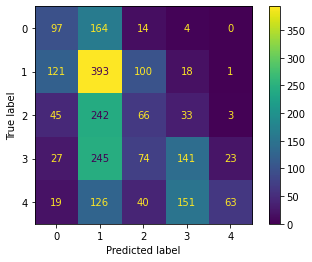

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
MulticlassCM = confusion_matrix( true_Y, test_predict_Y )
MultiClassDisp = ConfusionMatrixDisplay( MulticlassCM )
MultiClassDisp.plot()